### Importing libraries 

In [525]:
import pandas as pd
import seaborn as sns
import numpy as np
from dateutil import parser
import matplotlib as plt

### Importing Data

In [526]:
df = pd.read_csv('data/ytdataframe.csv')

In [527]:
df.head(5)

,Unnamed: 0,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,subscribers,totalViews,totalVideos,total polarity score,Label
0,0,-SejlHOXexc,Tech Tutorial,How to download facebook stories in your phone,Hey friends today we have another great topic ...,"['facebook stories in your phone', 'download f...",2019-11-02T14:25:35Z,968252,11104,NaN,338,PT3M55S,hd,False,140000,8642059,161,0.0082,non reputable
1,1,set4Kr8hX0w,Tech Tutorial,How to check whatsapp lastseen if hidden or bl...,Hello friends welcome to my channel Our today...,['How to check whatsapp lastseen if hidden or ...,2018-01-20T15:35:36Z,1477841,11931,NaN,860,PT4M44S,hd,False,140000,8642059,161,0.1820,non reputable
2,2,s4EYU1ptpIs,Tech Tutorial,How to change voice during call | Male female ...,Hey friends today we have another great topic ...,"['How to change voice during call', 'voice cha...",2021-11-30T17:37:11Z,542795,9114,NaN,332,PT5M21S,hd,False,140000,8642059,161,0.0890,non reputable
3,3,-lcPJAa6trw,Tech Tutorial,How to check who read my message in whatsapp g...,Hey friends today we have another great topic ...,['how to check who read message in whatsapp gr...,2018-05-07T15:12:51Z,322980,5359,NaN,266,PT3M,hd,False,140000,8642059,161,0.3620,non reputable
4,4,G1F6W7QhrWU,Tech Tutorial,How to Record Messenger calls -facebook messen...,Hey friends today we have another great topic ...,"['How to Record Messenger calls', 'facebook me...",2021-10-07T16:18:54Z,42017,321,NaN,19,PT4M23S,hd,False,140000,8642059,161,0.3250,non reputable


In [528]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            106 non-null    int64  
 1   video_id              106 non-null    object 
 2   channelTitle          106 non-null    object 
 3   title                 106 non-null    object 
 4   description           106 non-null    object 
 5   tags                  99 non-null     object 
 6   publishedAt           106 non-null    object 
 7   viewCount             106 non-null    int64  
 8   likeCount             106 non-null    int64  
 9   favouriteCount        0 non-null      float64
 10  commentCount          106 non-null    int64  
 11  duration              106 non-null    object 
 12  definition            106 non-null    object 
 13  caption               106 non-null    bool   
 14  subscribers           106 non-null    int64  
 15  totalViews            1

# Data preprocessing 

Checking duplicates

In [529]:
df.duplicated().sum()


0

In [530]:
df = df.drop_duplicates()
df.shape

(106, 19)

Checking null values

In [531]:
df.isnull().sum()


Unnamed: 0                0
video_id                  0
channelTitle              0
title                     0
description               0
tags                      7
publishedAt               0
viewCount                 0
likeCount                 0
favouriteCount          106
commentCount              0
duration                  0
definition                0
caption                   0
subscribers               0
totalViews                0
totalVideos               0
total polarity score      0
Label                     0
dtype: int64

Convert count columns to numeric

In [532]:
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

Convert publish date to year

In [533]:
df['publishedAt'] = df['publishedAt'].apply(lambda x: parser.parse(x)) 
df['pushblishYear'] = df['publishedAt'].apply(lambda x: x.strftime("%Y")) 

Convert duration to seconds

In [534]:
import isodate
df['durationSecs'] = df['duration'].apply(lambda x: isodate.parse_duration(x))
df['durationSecs'] = df['durationSecs'].astype('timedelta64[s]')

Add tag count

In [535]:


df['tagCount'] = df['tags'].apply(lambda x: 0 if x is np.nan else len(x))

Dropping columns we wont use

In [536]:
df = df.drop(['Unnamed: 0', 'publishedAt', 'duration', 'favouriteCount', 'video_id', 'tags'], axis=1)


# EDA

### Label distribution 

reputable        75
non reputable    31
Name: Label, dtype: int64

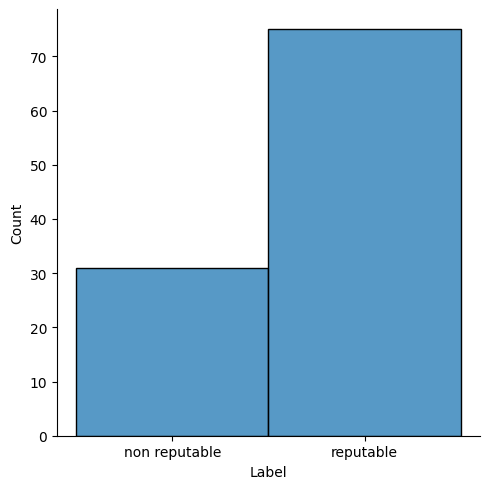

In [537]:
sns.displot(df, x="Label")
df["Label"].value_counts()

Our data is unbalanced so we might need oversampling

<AxesSubplot:xlabel='total polarity score', ylabel='likeCount'>

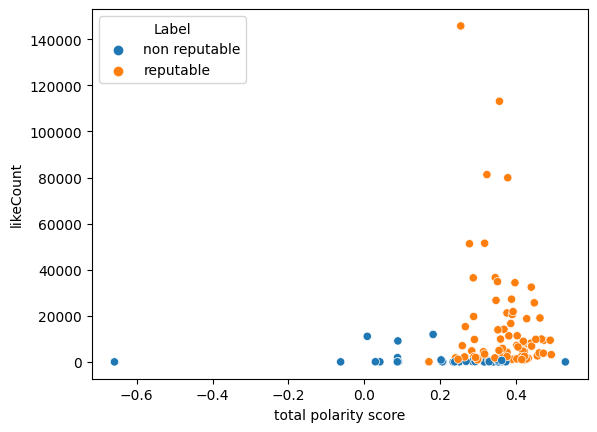

In [538]:
sns.scatterplot(x="total polarity score", y="likeCount", hue="Label", data = df)

# Modeling

In [539]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [540]:
le = LabelEncoder()

df2 = ['channelTitle', 'title', 'description', 'definition', 'caption', 'Label']

df[df2] = df[df2].apply(le.fit_transform)

df.head(1)

,channelTitle,title,description,viewCount,likeCount,commentCount,definition,caption,subscribers,totalViews,totalVideos,total polarity score,Label,pushblishYear,durationSecs,tagCount
0,13,44,30,968252.0,11104.0,338.0,0,0,140000,8642059,161,0.0082,0,2019,235.0,412


In [541]:
feat_col = ['channelTitle', 'title', 'description', 'viewCount', 'likeCount', 'definition', 'commentCount', 'caption', 'subscribers', 'totalViews', 'totalVideos', 'total polarity score', 'pushblishYear', 'durationSecs', 'tagCount']

X = df[feat_col] # Features
y = df.Label # Target variable

In [542]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

In [549]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16, max_iter=1000)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

In [550]:
from sklearn.metrics import classification_report
target_names = ['reputable', 'non reputable']
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

    reputable       0.88      0.88      0.88         8
non reputable       0.95      0.95      0.95        19

     accuracy                           0.93        27
    macro avg       0.91      0.91      0.91        27
 weighted avg       0.93      0.93      0.93        27

